In [1]:
from IPython.lib.deepreload import original_import
%load_ext autoreload
%autoreload 2

import ex4
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

In [2]:
PADDING = 4
BORDER_CUT = 15
ENABLE_ROTATION = False
INCLUDE_EDGE_FULL_STRIP = False
num_of_blurs = 1

garden_video = "Garden.mp4"
house_video = "House.mp4"
kessaria_video = "Kessaria.mp4"
boat_video = "boat.mp4"
Shinkansen_video = "Shinkansen.mp4"
waterfalls_video = "Iguazu.mp4"

iphone_folder = "Exercise Inputs/iphone"
farm_video = "farm.MOV"
camels_video = "camels.MOV"
tomb_video = "tomb.MOV"
church1_video = "church1.MOV"
church2_video = "church2.MOV"

# 0. Load video & blur
cur_video = boat_video

raw_frames = ex4.load_video_frames(filename=cur_video, spatial_downscale=1)
# raw_frames = ex4.load_video_frames(filename=cur_video,
#  inputs_folder=iphone_folder, spatial_downscale=2)

for _ in range(num_of_blurs):
    raw_frames = ex4.blur_video(raw_frames, ex4.REDUCE_KERNEL)

In [3]:
# 1. & Compute Motion
motion_data = ex4.compute_motion(raw_frames, BORDER_CUT)
# # print max value of theta in motion_data
# best = -1
# for _,_, theta in motion_data:
#     best=max(best, np.abs(theta))
# print("max angle found: ",best)

In [4]:
# invert if motion is right-to-left
if ex4.estimate_motion_dir(motion_data) == "RTL":
    raw_frames = raw_frames[::-1]
    motion_data = [(-u, -v, -theta) for u, v, theta in motion_data[::-1]]

In [5]:
# 2. Stabilize Video
stable_frames = ex4.stabilize_video(raw_frames, motion_data, enable_rotation=ENABLE_ROTATION)
stabilized_motion = [(u, 0, 0) for u, v, theta in motion_data]

In [6]:
# 3. Compute Path for motion composition: align all frames to same coordinate system
transforms = ex4.compute_cumulative_transforms(stabilized_motion)

In [7]:
geo = ex4.compute_canvas_geometry(transforms, raw_frames.shape[1],
                                          raw_frames.shape[2])

In [8]:
# pan = ex4.render_strip_panorama(stable_frames, transforms, geo, strip_anchor=0.5, strip_padding=PADDING, include_edge_full_strip=INCLUDE_EDGE_FULL_STRIP)
# plt.axis('off')
# plt.title("Panorama Mid Anchor - Without Stabilization")
# plt.imshow(pan)
# # save panorama with plt.imsave
# out_path = f"outputs/plots/{cur_video[:-4]}_unstable_panorama.png"
# plt.imsave(out_path, pan)
# print(f"{cur_video[:-4]} Panorama saved!")

In [9]:
# 4. Create Movie of Multi-Perspective mosaics
movie_frames = ex4.dynamic_mosaic(stable_frames, transforms, geo, num_views=10, back_n_forth=False, include_edge_full_strip=INCLUDE_EDGE_FULL_STRIP)

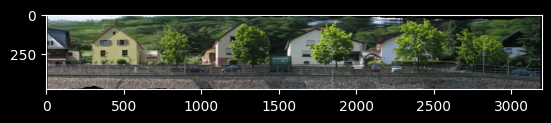

In [10]:
plt.imshow(movie_frames[len(movie_frames)//2])

In [11]:
import imageio

imageio.mimsave(f"outputs/movies/{cur_video[:-4]}_movie.mp4", movie_frames,
                fps=10)
print(f"{cur_video[:-4]} Movie saved!")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (3198, 480) to (3200, 480) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


boat Movie saved!


### for debugging: render 3 panoramas with different anchors and show them

In [12]:
# 3. Render
panorama_left = ex4.render_strip_panorama(stable_frames, transforms, geo, strip_anchor=0.2, strip_padding=PADDING, include_edge_full_strip=INCLUDE_EDGE_FULL_STRIP)
print("Panorama Left Anchor 0.2 done.")
panorama_mid = ex4.render_strip_panorama(stable_frames, transforms, geo, strip_anchor=0.5, strip_padding=PADDING, include_edge_full_strip=INCLUDE_EDGE_FULL_STRIP)
print("Panorama Mid Anchor 0.5 done.")
panorama_right = ex4.render_strip_panorama(stable_frames, transforms, geo, strip_anchor=0.8, strip_padding=PADDING, include_edge_full_strip=INCLUDE_EDGE_FULL_STRIP)
print("Panorama Right Anchor 0.8 done.")
print(">>> done.")

Panorama Left Anchor 0.2 done.
Panorama Mid Anchor 0.5 done.
Panorama Right Anchor 0.8 done.
>>> done.


initializing plot...


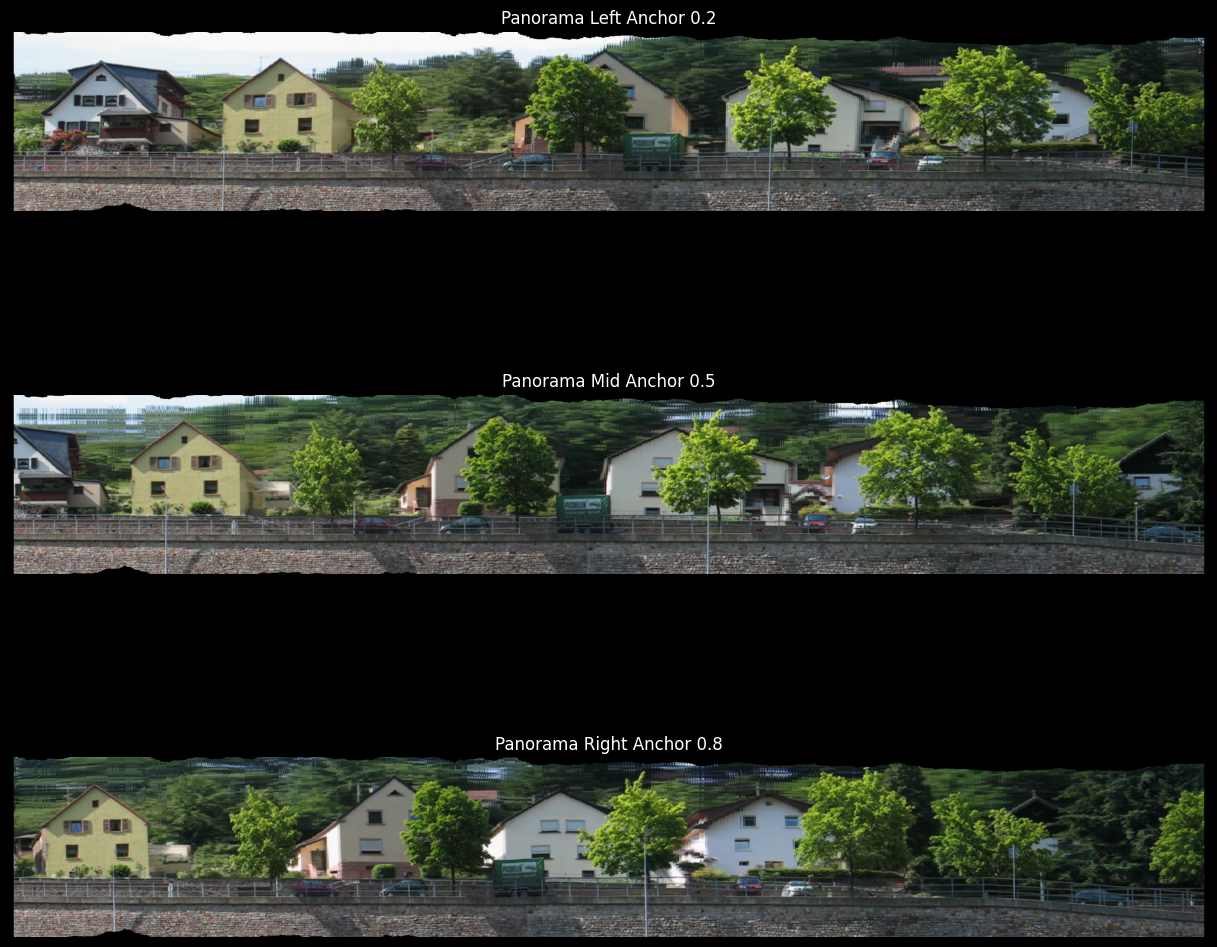

plot done.


In [13]:
# show all 3 panoramas one line below the other
# with tight layout, no vertical padding between lines
print("initializing plot...")
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.imshow(panorama_left)
plt.title("Panorama Left Anchor 0.2")
plt.axis('off')
plt.subplot(3, 1, 2)
plt.imshow(panorama_mid)
plt.title("Panorama Mid Anchor 0.5")
plt.axis('off')
plt.subplot(3, 1, 3)
plt.imshow(panorama_right)
plt.title("Panorama Right Anchor 0.8")
plt.axis('off')
plt.tight_layout(pad=0.1)
plt.show()
print("plot done.")

In [14]:
import os
# import matplotlib.pyplot as plt

os.makedirs("outputs/plots", exist_ok=True)

print("initializing plot...")
fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(3, 1, 1)
ax1.imshow(panorama_left)
ax1.set_title("Panorama Left Anchor 0.2")
ax1.axis("off")

ax2 = fig.add_subplot(3, 1, 2)
ax2.imshow(panorama_mid)
ax2.set_title("Panorama Mid Anchor 0.5")
ax2.axis("off")

ax3 = fig.add_subplot(3, 1, 3)
ax3.imshow(panorama_right)
ax3.set_title("Panorama Right Anchor 0.8")
ax3.axis("off")

fig.tight_layout(pad=0.0)

out_path = f"outputs/plots/{cur_video[:-4]}_panoramas.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight")
plt.close(fig)

print(f"saved: {out_path}")

initializing plot...
saved: outputs/plots/boat_panoramas.png


In [15]:
# create and save a plot of first, middle and last frames of INPUT video. show them side by side on same row.
n = len(raw_frames)
idxs = [0, n // 2, n - 1]
frames = [raw_frames[i] for i in idxs]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ["First frame", "Middle frame", "Last frame"]

for ax, frame, title in zip(axes, frames, titles):
    ax.imshow(frame)
    ax.set_title(title)
    ax.axis("off")

fig.tight_layout(pad=0.0)

out_path = f"outputs/plots/{cur_video[:-4]}_input_frames_1st_mid_last.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight")
plt.close(fig)

print(f"saved: {out_path}")

saved: outputs/plots/boat_input_frames_1st_mid_last.png


In [16]:
# create and save a plot of first, middle and last frames of INPUT video. show them side by side on same row.
n = len(raw_frames)
idxs = [0, n // 2, n - 1]
# frames = [raw_frames[i] for i in idxs]
frames = [panorama_left, panorama_mid, panorama_right]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Panorama Left Anchor 0.2", "Panorama Middle Anchor 0.5", "Panorama Right Anchor 0.8"]

for ax, frame, title in zip(axes, frames, titles):
    ax.imshow(frame)
    ax.set_title(title)
    ax.axis("off")

fig.tight_layout(pad=0.5)

out_path = f"outputs/plots/{cur_video[:-4]}_3_panoramas.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight")
plt.close(fig)

print(f"saved: {out_path}")

saved: outputs/plots/boat_3_panoramas.png


In [17]:
# Before stabilization (raw input)
raw0 = raw_frames[0]
raw1 = raw_frames[1]

# After stabilization (note: stable_frames aligns content; frame[0] is typically unchanged)
stab0 = stable_frames[0]
stab1 = stable_frames[1]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].imshow(raw0)
axes[0, 0].set_title("Input: frame 0 (before)")
axes[0, 0].axis("off")

axes[0, 1].imshow(raw1)
axes[0, 1].set_title("Input: frame 1 (before)")
axes[0, 1].axis("off")

axes[1, 0].imshow(stab0)
axes[1, 0].set_title("Stabilized: frame 0 (after)")
axes[1, 0].axis("off")

axes[1, 1].imshow(stab1)
axes[1, 1].set_title("Stabilized: frame 1 (after)")
axes[1, 1].axis("off")

fig.tight_layout(pad=0.2)

out_path = f"outputs/plots/{cur_video[:-4]}_stabilization_frame0_vs_frame1.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight")
plt.close(fig)

print(f"saved: {out_path}")

saved: outputs/plots/boat_stabilization_frame0_vs_frame1.png


In [18]:
# import os
# import numpy as np
# from matplotlib.figure import Figure
# from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
#
# # uses your project warp (SciPy map_coordinates), so no cv2 dependency
# from ex4 import warp_image  # adjust import if needed
#
# os.makedirs("outputs/plots", exist_ok=True)
#
# # frames are float64 in [0, 1] in your pipeline
# f0 = raw_frames[0]
# f1 = raw_frames[1]
#
# # motion_data[0] corresponds to motion from frame0 -> frame1
# u, v, theta = motion_data[0]
#
# # warp frame1 into frame0 coordinate system
# f1_warp = warp_image(f1, u, v, theta)
#
# alpha = 0.5
# overlay = np.clip(alpha * f0 + (1.0 - alpha) * f1_warp, 0.0, 1.0)
#
# # save overlay without pyplot
# fig = Figure(figsize=(8, 6), dpi=200)
# FigureCanvas(fig)
# ax = fig.add_subplot(1, 1, 1)
# ax.imshow(overlay)
# ax.set_title("Overlay: frame0 + warped(frame1)")
# ax.axis("off")
# fig.tight_layout(pad=0.2)
#
# out_path = f"outputs/plots/{cur_video[:-4]}_overlay_frame0_frame1_warped.png"
# fig.savefig(out_path, bbox_inches="tight")
# print(f"saved: {out_path}")

In [19]:
import os
import numpy as np
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import ex4  # uses ex4.warp_image

os.makedirs("outputs/plots", exist_ok=True)

# --- pick frames (0-based indexing) ---
i_ref = 85   # frame 1
i_tgt = i_ref+1   # frame 10

f_ref = raw_frames[i_ref]
f_tgt = raw_frames[i_tgt]

# motion_data[k] = (u,v,theta) aligns frame(k+1) to frame(k) in LK,
# but in this project it's used as per-step motion between consecutive frames.
# Compose steps i_ref -> i_tgt by summing translations and rotations (small-angle model).
u_cum = 0.0
v_cum = 0.0
theta_cum = 0.0
for k in range(i_ref, i_tgt):
    du, dv, dtheta = motion_data[k]
    u_cum += du
    v_cum += dv
    theta_cum += dtheta

# Warp target frame into reference frame coordinates
f_tgt_warp = ex4.warp_image(f_tgt, u_cum, v_cum, theta_cum)

alpha = 0.5
overlay = np.clip(alpha * f_ref + (1.0 - alpha) * f_tgt_warp, 0.0, 1.0)

# Save without pyplot (avoids pyplot state issues)
fig = Figure(figsize=(8, 6), dpi=200)
FigureCanvas(fig)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(overlay)
ax.set_title(f"Overlay: frame {i_ref+1} + warped(frame {i_tgt+1})\\n(u={u_cum:.2f}, v={v_cum:.2f}, θ={theta_cum:.4f})")
ax.axis("off")
fig.tight_layout(pad=0.2)

out_path = f"outputs/plots/{cur_video[:-4]}_overlay_frame{i_ref+1:02d}_frame{i_tgt+1:02d}_cumulative.png"
fig.savefig(out_path, bbox_inches="tight")
print(f"saved: {out_path}")

saved: outputs/plots/boat_overlay_frame86_frame87_cumulative.png


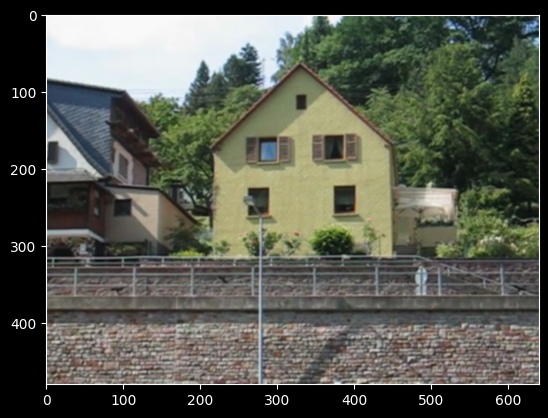

In [20]:
plt.imshow(raw_frames[i_ref])

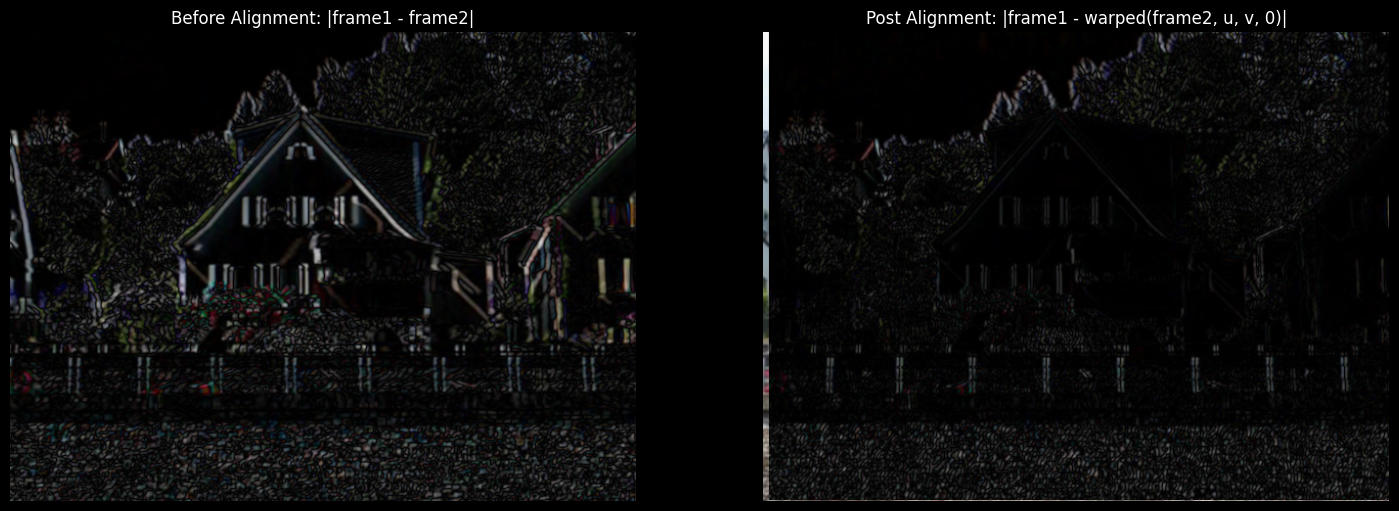

In [64]:

# assumes: im1, im2 are (H,W) grayscale float images (preferably in [0,1])
# assumes: u, v, theta are already computed (e.g., by align_pair / LK)
# assumes: warp_image is available in scope (imported from `ex4.py`)
im1 = raw_frames[1]
im2 = raw_frames[2]
diff_before = np.abs(im1 - im2)
u,v,theta = motion_data[i_ref]
warped_translation = ex4.warp_image(im2, u=u, v=v, theta=0.0)
diff_translation = np.abs(im1 - warped_translation)

warped_full = ex4.warp_image(im2, u=u, v=v, theta=theta)
diff_full = np.abs(im1 - warped_full)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

axes[0].imshow(diff_before)
axes[0].set_title("Before Alignment: |frame1 - frame2|")
axes[0].axis("off")

axes[1].imshow(diff_translation)
axes[1].set_title("Post Alignment: |frame1 - warped(frame2, u, v, 0)|")
axes[1].axis("off")

fig.savefig("outputs/plots/frame_diffs.png", dpi=200, bbox_inches="tight")
plt.show()

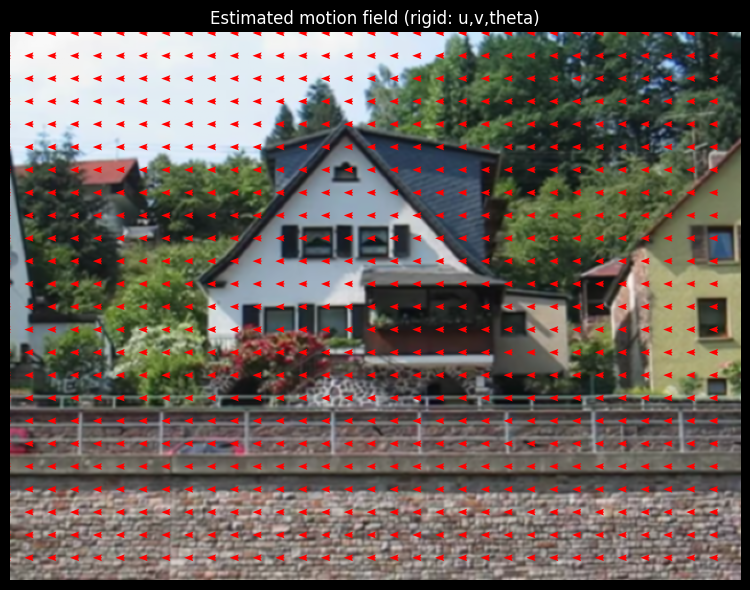

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# assumes: im2 is (H,W) or (H,W,3), and u, v, theta are floats (pixels, pixels, radians)

h, w = im2.shape[:2]
step = 20

xs = np.arange(0, w, step, dtype=np.float64)
ys = np.arange(0, h, step, dtype=np.float64)
X, Y = np.meshgrid(xs, ys)

xc = X - w / 2.0
yc = Y - h / 2.0
c, s = np.cos(theta), np.sin(theta)

Xw = (xc * c + yc * s) + u + w / 2.0
Yw = (-xc * s + yc * c) + v + h / 2.0

U = Xw - X
V = Yw - Y

plt.figure(figsize=(8, 6))
plt.imshow(im2, cmap="gray" if im2.ndim == 2 else None)

plt.quiver(
    X, Y, U, V,
    color="red",
    angles="xy",
    scale_units="xy",
    scale=0.7,         # smaller => longer arrows
    width=0.01,       # thicker shafts
    headwidth=6,       # bigger heads
    headlength=8,
    headaxislength=7,
)

plt.title("Estimated motion field (rigid: u,v,theta)")
plt.axis("off")
plt.tight_layout()
plt.show()

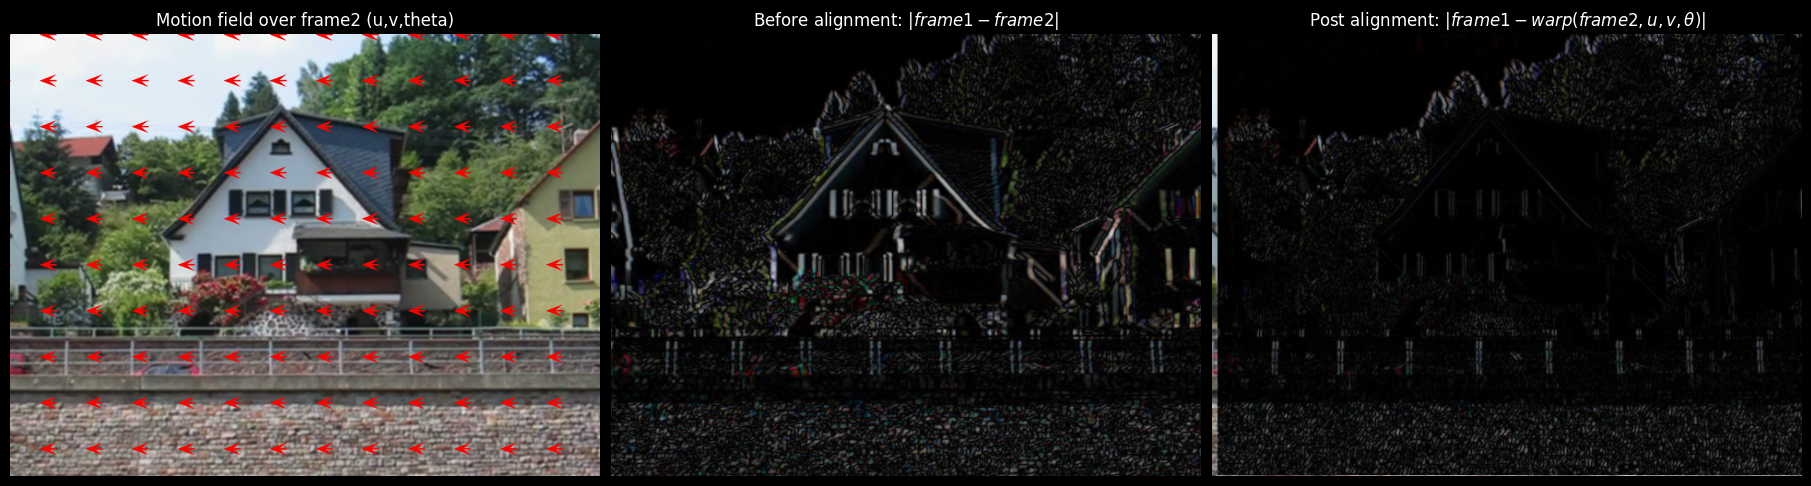

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt

# assumes: im1, im2, u, v, theta are already in memory
# assumes: warp_image is available (e.g., from `ex4.py`)


# --- motion field grid (same rigid model as warp_image: rotate about center + translate) ---
h, w = im2.shape[:2]
step = 50

xs = np.arange(0, w, step, dtype=np.float64)
ys = np.arange(0, h, step, dtype=np.float64)
X, Y = np.meshgrid(xs, ys)

xc = X - w / 2.0
yc = Y - h / 2.0
c, s = np.cos(theta), np.sin(theta)

Xw = (xc * c + yc * s) + u + w / 2.0
Yw = (-xc * s + yc * c) + v + h / 2.0

U = Xw - X
V = Yw - Y

# --- plot: quiver (left), diffs (middle/right) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# 1) quiver over im2
axes[0].imshow(im2, cmap="gray" if im2.ndim == 2 else None)
axes[0].quiver(
    X, Y, U, V,
    color="red",
    angles="xy",
    scale_units="xy",
    scale=0.3,        # smaller => longer arrows
    width=0.01,
    headwidth=9,
    headlength=12,
    headaxislength=7,
)
axes[0].set_title("Motion field over frame2 (u,v,theta)")
axes[0].axis("off")

# 2) translation-only abs diff
axes[1].imshow(diff_before, cmap="gray")
axes[1].set_title(r"Before alignment: $|frame1 - frame2|$")
axes[1].axis("off")

# 3) full alignment abs diff
axes[2].imshow(diff_translation, cmap="gray")
axes[2].set_title(r"Post alignment: $|frame1 - warp(frame2,u,v,\theta)|$")
axes[2].axis("off")

os.makedirs("outputs/plots", exist_ok=True)
fig.savefig("outputs/plots/quiv_and_diffs.png", dpi=200, bbox_inches="tight")
plt.show()